# Notebook Title: Traffic Prediction Analysis

### Problem Statement and Goals

The core objective of this notebook is to forecast traffic volume (number of vehicles) and speed at various junctions using time series analysis. We are particularly interested in identifying the best-performing predictive model for our dataset which consists of a timeseries collection of traffic volume and speed at four specific junctions, collected hourly from February to June 2014 via sensors.

### Dataset Context and Background

- **Source:** The traffic dataset, spanning February to June 2014, from Denmark
- **Collection Methods:** Data was meticulously gathered by 490 sensors installed at junctions, capturing vehicle counts and speeds at regular intervals. 
- **Preprocessing:** The original dataset underwent rigorous preprocessing to enhance its suitability for analysis. This entailed:
    - Downsampling to 1 million rows via random sampling due to computational constraints.
    - Removal of extraneous columns (REPORT_ID, avgMeasuredTime, _id, medianMeasuredTime, status).
    - Renaming of the 'extID' column to 'junction' for clarity.
    - Data was saved and uploaded to Hugging Face Hub under the dataset name "mugithi/down_sampled_file_traffic_dataset". 

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, Sequential, callbacks
from tensorflow.keras.layers import LSTM, Dropout, Dense, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import warnings
import math
import glob
import os
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")

2024-02-24 15:34:32.553129: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-24 15:34:32.605095: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 15:34:32.605131: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 15:34:32.606629: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-24 15:34:32.615250: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-24 15:34:32.615971: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Raw Data Processing

In [2]:
def combine_csv_and_load_data(directory):
    # Step 1: Get all CSV file paths
    csv_files = glob.glob(os.path.join(directory, '*.csv'))
    # Step 2: Read each CSV file and append to list
    df_list = []
    for file in csv_files:
        df = pd.read_csv(file)
        df_list.append(df)
    # Step 3: Concatenate all dataframes
    combined_df = pd.concat(df_list, ignore_index=True)
    # Step 4: Optionally save to a new CSV file
    combined_df.to_csv(os.path.join('data/combined_data_traffic.csv'), index=False)
    # Step 5: Return the combined dataframe
    return combined_df
directory = 'data/trafficData'
combined_df = combine_csv_and_load_data(directory)

In [3]:
print(combined_df.columns.tolist())

['status', 'avgMeasuredTime', 'avgSpeed', 'extID', 'medianMeasuredTime', 'TIMESTAMP', 'vehicleCount', '_id', 'REPORT_ID']


In [4]:
# Drop specified columns, note that 'avgMeasuredTime' is mentioned twice, but we need to drop it only once.
combined_df.drop(['REPORT_ID', 'avgMeasuredTime', '_id', 'medianMeasuredTime','status'], axis=1, inplace=True)

# Rename 'extID' column to 'junction'
combined_df.rename(columns={'extID': 'junction'}, inplace=True)

In [5]:
combined_df['TIMESTAMP']=pd.to_datetime(combined_df['TIMESTAMP'])
combined_df["Year"]=combined_df['TIMESTAMP'].dt.year
combined_df["Month"]=combined_df['TIMESTAMP'].dt.month
combined_df["Date_no"]=combined_df['TIMESTAMP'].dt.day
combined_df["Hour"]=combined_df['TIMESTAMP'].dt.hour
combined_df["Day"]= combined_df['TIMESTAMP'].dt.strftime("%A")

In [6]:
# Sort the DataFrame by the 'TIMESTAMP' column in ascending order
combined_df = combined_df.sort_values(by='TIMESTAMP')

# Reset the index of the DataFrame, dropping the old index
combined_df = combined_df.reset_index(drop=True)

## Saving the data

In [7]:
# Use train_test_split for the 80/20 split
train_df, test_df = train_test_split(combined_df, test_size=0.2, shuffle=False)

# Reset the index
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Save as CSV files
train_df.to_csv('data/train.csv', index=False)
test_df.to_csv('data/test.csv', index=False)

In [8]:
# !pip install huggingface_hub
# !pip install datasets 

In [9]:
# from huggingface_hub import notebook_login
# notebook_login()

In [10]:
# from datasets import load_dataset

# # Load dataset into Train & Test splits
# dataset_dict = load_dataset('csv', data_files={'train': 'data/train.csv'})

# # Prepare for upload - you'll need a Hugging Face token
# # Ensure you're logged in with `huggingface-cli login` or use `use_auth_token` parameter
# dataset_dict.push_to_hub("mugithi/down_sampled_file_traffic_dataset")


## Data Retrieval and Downsampling

In [11]:
import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
df=pd.read_csv("data/combined_data_traffic.csv")

In [13]:
df.head()

,status,avgMeasuredTime,avgSpeed,extID,medianMeasuredTime,TIMESTAMP,vehicleCount,_id,REPORT_ID
0,OK,109,52,612,109,2014-02-13T11:30:00,4,189944,187085
1,OK,94,60,612,94,2014-02-13T11:35:00,0,190393,187085
2,OK,169,33,612,169,2014-02-13T11:40:00,2,190842,187085
3,OK,132,43,612,132,2014-02-13T11:45:00,4,191291,187085
4,OK,131,43,612,131,2014-02-13T11:50:00,5,191740,187085


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13577132 entries, 0 to 13577131
Data columns (total 9 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   status              object
 1   avgMeasuredTime     int64 
 2   avgSpeed            int64 
 3   extID               int64 
 4   medianMeasuredTime  int64 
 5   TIMESTAMP           object
 6   vehicleCount        int64 
 7   _id                 int64 
 8   REPORT_ID           int64 
dtypes: int64(7), object(2)
memory usage: 932.3+ MB


In [15]:
df["TIMESTAMP"]= pd.to_datetime(df["TIMESTAMP"])
df = df.drop(["status","avgMeasuredTime","medianMeasuredTime","_id","REPORT_ID"], axis=1) #dropping IDs
df = df.rename(columns={
    'avgSpeed': 'Speed',
    'extID': 'Junction',
    'TIMESTAMP': 'DateTime',
    'vehicleCount': 'Vehicles'
})

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sum vehicle count per junction
junction_vehicle_sum = df.groupby('Junction')['Vehicles'].sum().reset_index()

# Display the result
print(junction_vehicle_sum)

     Junction  Vehicles
0         610     11847
1         611      3097
2         612     20885
3         613     54325
4         614     29968
..        ...       ...
444      1054    191010
445      1055     75777
446      1056      1383
447      1057    265244
448      1058     30320

[449 rows x 2 columns]


In [17]:
filtered_junction = junction_vehicle_sum[junction_vehicle_sum['Vehicles'] > 435000].reset_index(drop=True)['Junction']

In [18]:
filtered_junction

0     646
1     781
2     852
3    1048
Name: Junction, dtype: int64

In [19]:
# Filter df using 'isin' for efficient matching
df = df[df['Junction'].isin(filtered_junction)].reset_index(drop=True)

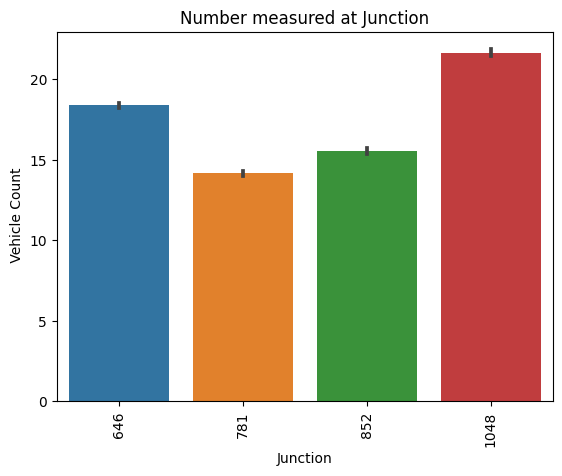

In [20]:
# Plotting the sum of vehicles per junction
sns.barplot(data=df[df['Junction'].isin(filtered_junction)], x='Junction', y='Vehicles')
plt.xlabel('Junction')
plt.ylabel(' Vehicle Count')
plt.title('Number measured at Junction')
plt.xticks(rotation=90)  # Rotate labels to avoid overlap
plt.show()

# Feature Engineering

At this step, I am creating a few new features out of DateTime. 
Namely:
* Year
* Month 
* Date in the given month
* Days of week 
* Hour

In [21]:
#Exploring more features 
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

,Speed,Junction,DateTime,Vehicles,Year,Month,Date_no,Hour,Day
0,76,852,2014-02-13 11:30:00,22,2014,2,13,11,Thursday
1,74,852,2014-02-13 11:35:00,26,2014,2,13,11,Thursday
2,72,852,2014-02-13 11:40:00,17,2014,2,13,11,Thursday
3,66,852,2014-02-13 11:45:00,12,2014,2,13,11,Thursday
4,70,852,2014-02-13 11:50:00,16,2014,2,13,11,Thursday


# Exploratory Data Analysis

Plotting the newly created features

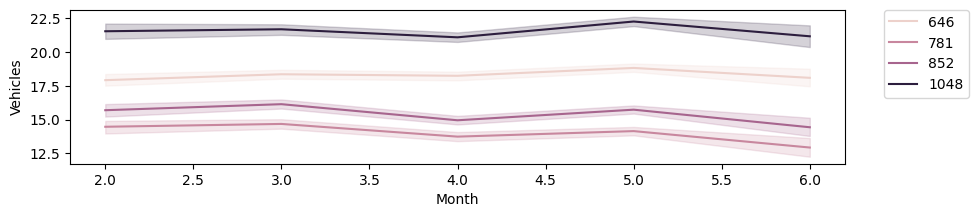

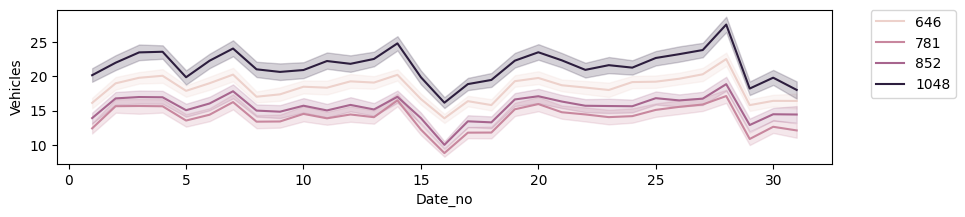

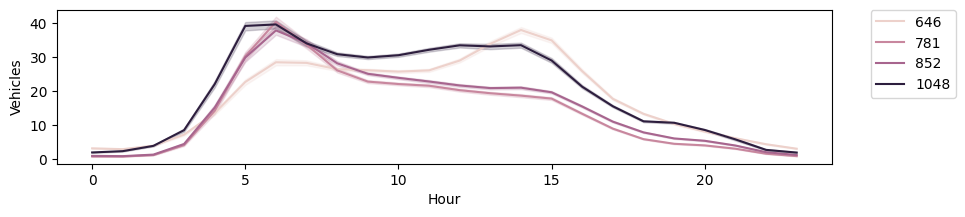

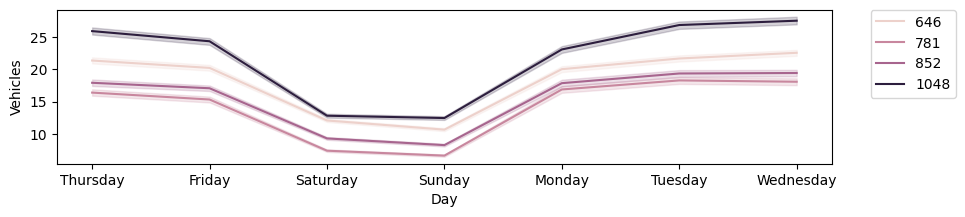

In [22]:
#Let's plot the Timeseries
new_features = ["Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10, 2))
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 0, 'Date')

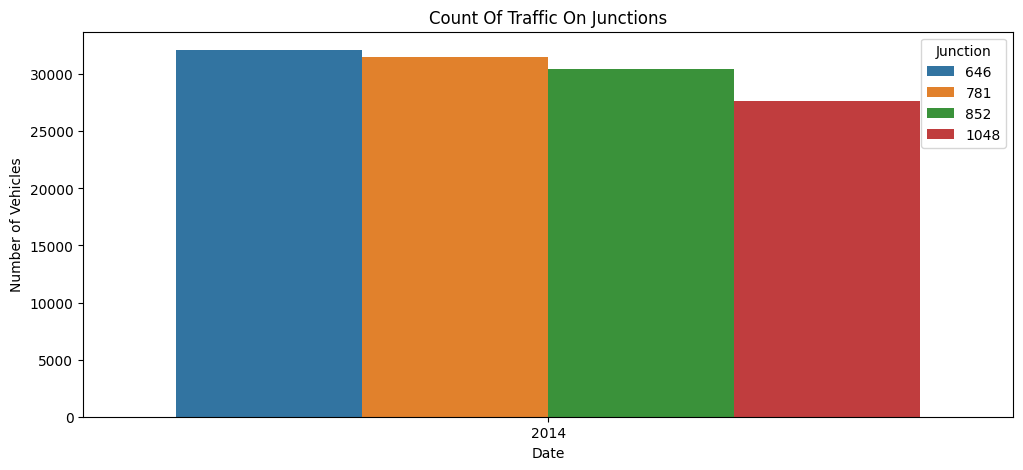

In [23]:
plt.figure(figsize=(12,5))
count = sns.countplot(data=df, x =df["Year"], hue="Junction")
count.set_title("Count Of Traffic On Junctions")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

The count filters for junctions that had volume count of greater than 435000 in 2014

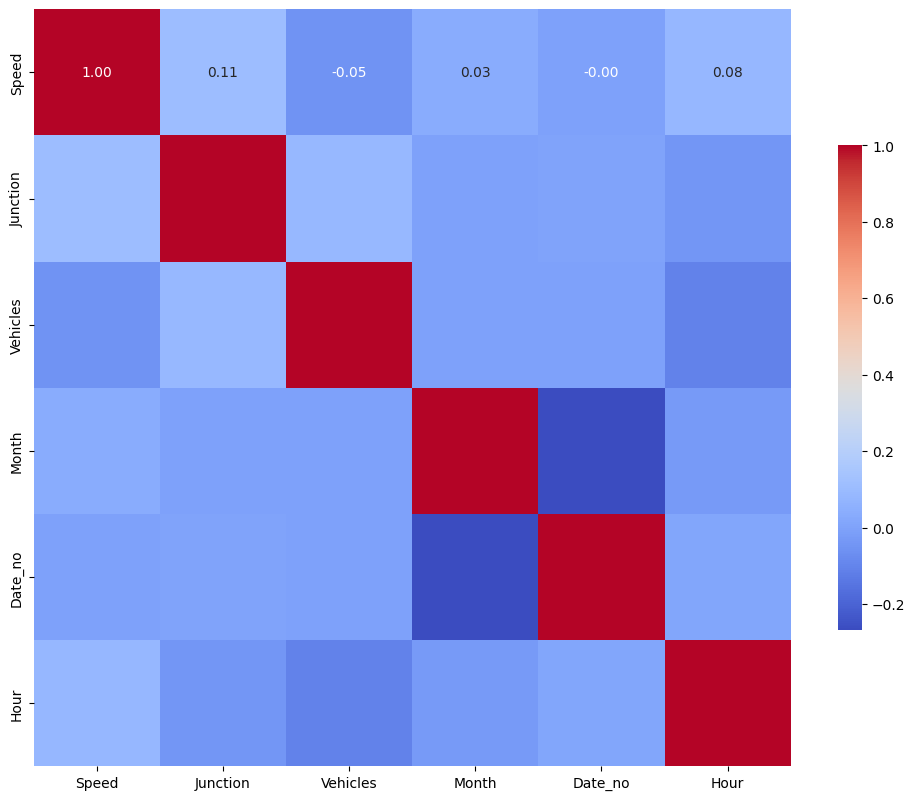

In [24]:
numeric_df = df[df.columns[~df.columns.isin(['Year'])]].select_dtypes(include=[np.number])

# Compute correlation matrix
corrmat = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 10))
# Annotate each cell with the numeric value using formatting to limit the number of decimals
sns.heatmap(corrmat, annot=True, fmt=".2f", square=True, cmap='coolwarm', cbar_kws={'shrink': .5})
plt.tight_layout() 
plt.show()

**Conclusions that I have come to draw after this EDA**

* There is a weak corelation between time of day, day of week and speed

# Data Transformation and Preprocessing

**In this step I will be following the subsequent order:**

* Creating different frames for each Vehicles and Speed and plotting them
* Transforming the series and plotting them
* Performing the Augmented Dickey-Fuller test to check the seasonality of transformed series
* Creating test and train sets

### Check for NaN

In [25]:
# Check for NaN values in 'Junction', 'Vehicles', and 'Speed' columns
nan_in_junction = df['Junction'].isna().any()
nan_in_vehicles = df['Vehicles'].isna().any()
nan_in_speed = df['Speed'].isna().any()

# Print the results
print(f"NaN values in 'Junction': {nan_in_junction}")
print(f"NaN values in 'Vehicles': {nan_in_vehicles}")
print(f"NaN values in 'Speed': {nan_in_speed}")


NaN values in 'Junction': False
NaN values in 'Vehicles': False
NaN values in 'Speed': False


In [26]:
df = df.dropna(subset=['Vehicles', 'Speed'])

In [27]:
# Check for NaN values in 'Junction', 'Vehicles', and 'Speed' columns
nan_in_junction = df['Junction'].isna().any()
nan_in_vehicles = df['Vehicles'].isna().any()
nan_in_speed = df['Speed'].isna().any()

# Print the results
print(f"NaN values in 'Junction': {nan_in_junction}")
print(f"NaN values in 'Vehicles': {nan_in_vehicles}")
print(f"NaN values in 'Speed': {nan_in_speed}")


NaN values in 'Junction': False
NaN values in 'Vehicles': False
NaN values in 'Speed': False


### Create a dataset and for the  Junction `646`

In [28]:
# Select subset of original DataFrame where Junction is 646
# And only include columns DateTime and Vehicles or Speed respectively

df_vehicles = df[df['Junction'] == 646][['DateTime', 'Vehicles']]
df_speed = df[df['Junction'] == 646][['DateTime', 'Speed']]

In [29]:
# Convert DateTime columns to datetime format in both DataFrames
df_vehicles['DateTime'] = pd.to_datetime(df['DateTime'])
df_speed['DateTime'] = pd.to_datetime(df['DateTime'])

# Set DateTime columns as index in both DataFrames 
df_vehicles.set_index('DateTime', inplace=True)
df_speed.set_index('DateTime', inplace=True)


In [30]:
df_vehicles.shape, df_speed.shape

((32117, 1), (32117, 1))

In [31]:
df_vehicles.head()

,Vehicles
DateTime,
2014-02-13 11:30:00,35
2014-02-13 11:35:00,26
2014-02-13 11:40:00,31
2014-02-13 11:45:00,28
2014-02-13 11:50:00,35


In [32]:
df_speed.head()

,Speed
DateTime,
2014-02-13 11:30:00,91
2014-02-13 11:35:00,100
2014-02-13 11:40:00,108
2014-02-13 11:45:00,106
2014-02-13 11:50:00,109


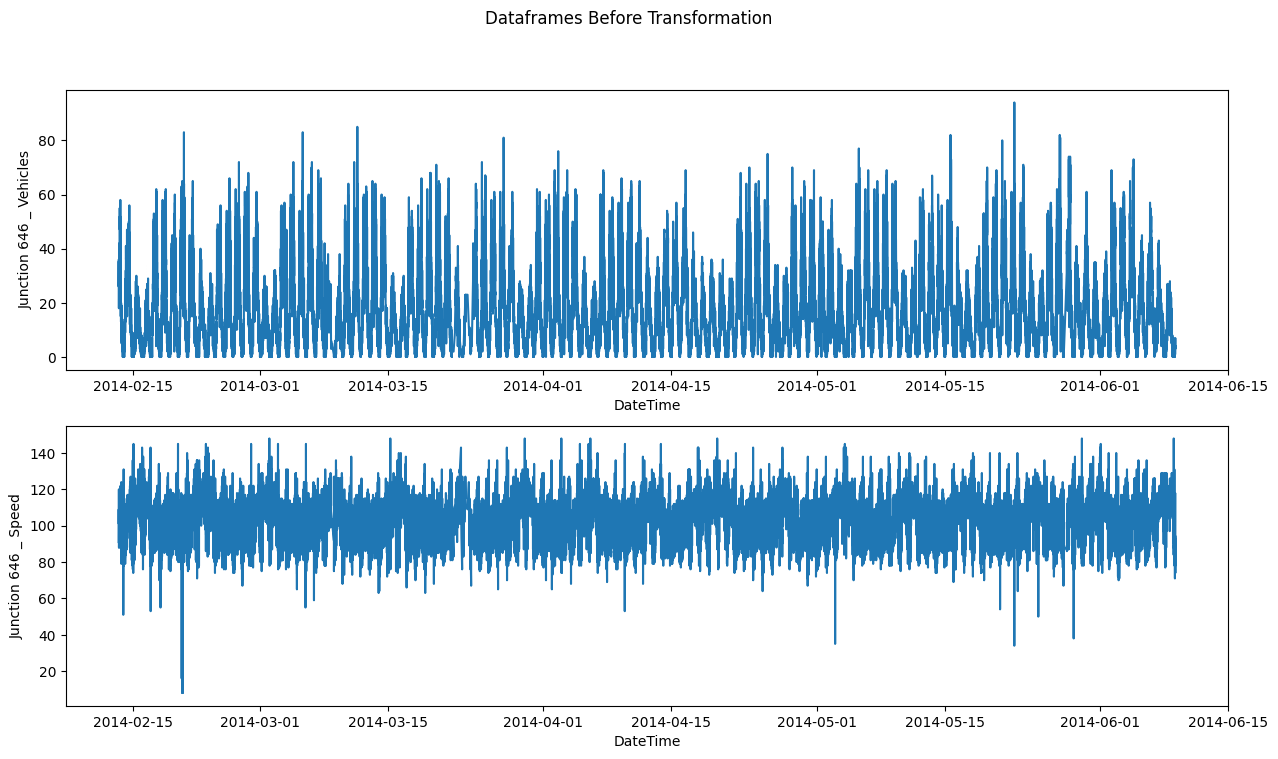

In [33]:
list_dfs = [df_vehicles, df_speed]   

#Function to plot comparitive plots of dataframes
def Sub_Plots(df_vehicles, df_speed, title):
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_vehicles)
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 646 _ Vehicles")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_speed)
    axes[1].set(ylabel ="Junction 646 _ Speed")
    
    
#Plotting the dataframe to check for stationarity
Sub_Plots(df_vehicles.Vehicles, df_speed.Speed,"Dataframes Before Transformation")

A time series is stationary if it does not have a trend or seasonality. However, in the EDA, we saw a weekly seasonality and an upwards trend over the years. In the above plot, it is again established that Junctions one and two have an upward trend. If we limit the span we will be able to further see the weekly seasonality. I will be spairing that step at this point and moving on with the respective transforms on datasets.

**Steps for Transforming:**
* Normalizing 
* Differencing 

In [34]:
# Define Normalize function to normalize a dataframe
def Normalize(df):
    # Calculate the average of the dataframe
    average = df.mean()
    # Calculate the standard deviation of the dataframe
    stdev = df.std()
    # Normalize the dataframe by subtracting the mean and dividing by the standard deviation
    df_normalized = (df - average) / stdev
    # Return the normalized dataframe, along with the mean and standard deviation for potential future use
    return df_normalized, average, stdev

# Define Difference function to calculate differences over a specified interval in a dataframe 
def Difference(df, interval):
    # Initialize an empty list to store differences 
    diff = []
    
    # Iterate through the dataframe, starting from index 'interval'
    for i in range(interval, len(df)):
        # Calculate difference between current and past value (based on 'interval') 
        value = df.iloc[i] - df.iloc[i - interval]
        # Add calculated difference to list  
        diff.append(value)
    
    return diff

In accordance with the above observations, Differencing to eliminate the seasonality should be performed as follows:
* For Vehicles one, I will be taking a difference of weekly values. 
* For Speed two,consecutive days is a better choice

In [35]:
# Apply Normalize function to Vehicles column on DataFrame 'df_vehicles'
df_N_vehicles, av_vehicles, std_vehicles = Normalize(df_vehicles['Vehicles'])

# Apply Difference function on normalized DataFrame with a week's interval (24hrs * 7days)
Diff_vehicles = Difference(df_N_vehicles, interval=(24*7))

# Trim DataFrame to exclude first week's data 
df_N_vehicles = df_N_vehicles[24*7:]

# Retain original Vehicles for denormalization and include Diff column:
df_N_vehicles = pd.DataFrame({
    'Vehicles': df_vehicles['Vehicles'][24*7:],  # Aligned with the trimmed data
    'Norm': df_N_vehicles.values.flatten(),
    'Diff': Diff_vehicles
})

df_N_vehicles["Diff"]= Diff_vehicles
#---------


# Repeat process for Speed column on DataFrame 'df_speed' 
df_N_speed, av_speed, std_speed = Normalize(df_speed['Speed'])

# Apply Difference function on normalized DataFrame with a day's interval (24hrs)
Diff_speed = Difference(df_N_speed, interval=(24))

# Trim DataFrame to exclude first day's of data
df_N_speed = df_N_speed[24:]

# Retain original Speed for denormalization and include Diff column:
df_N_speed = pd.DataFrame({
    'Speed': df_speed['Speed'][24:],  # Aligned with the trimmed data
    'Norm': df_N_speed.values.flatten(),
    'Diff': Diff_speed
})



df_N_speed["Diff"]= Diff_speed



**Plots of Transformed Dataframe**

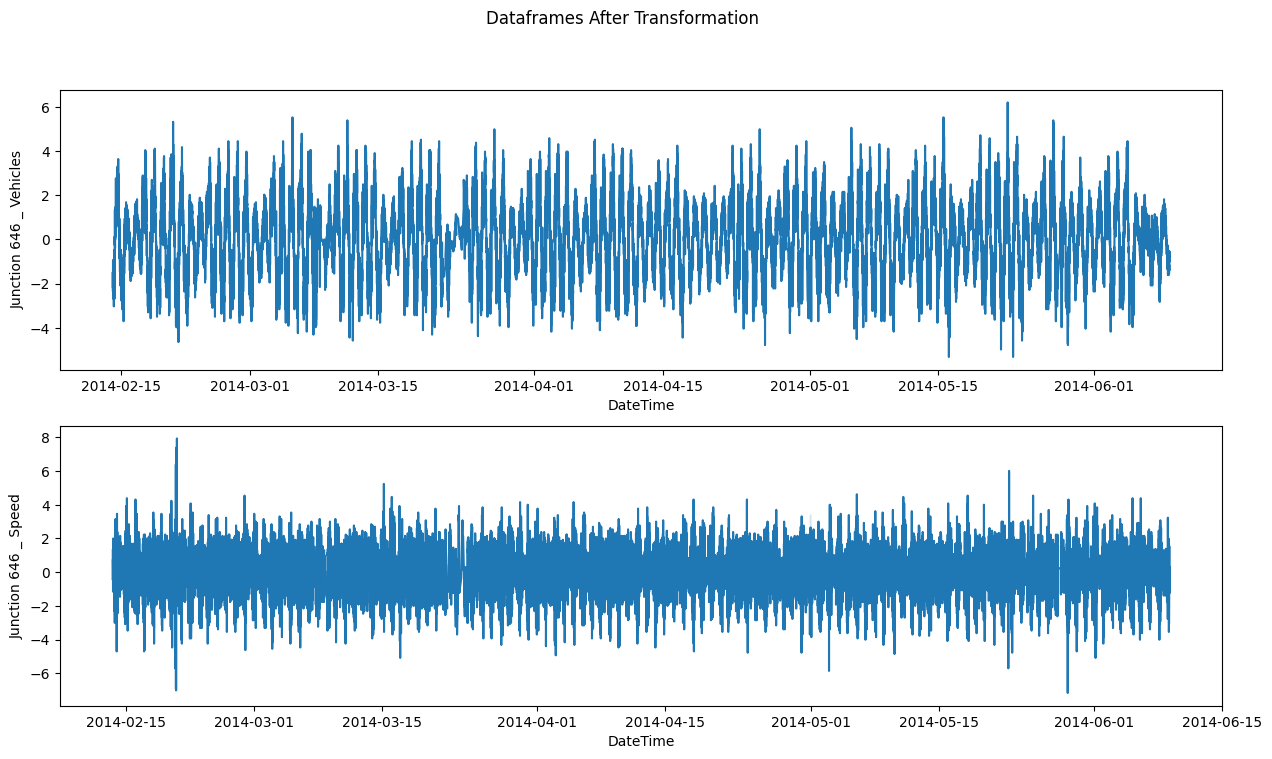

In [36]:
# Use subplots function to plot transformed dataframes 
Sub_Plots(df_N_vehicles.Diff, df_N_speed.Diff,"Dataframes After Transformation")

The plots above seem linear. To ensure they are Stationary I will be performing an Augmented Dickey-Fuller test. 

In [37]:
from pandas import Series

def Stationary_check(df):
    # Ensure df is a pandas Series
    if not isinstance(df, Series):
        df = Series(df)
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary") 

# Assuming df_N_vehicles["Diff"] and df_N_speed["Diff"] are pandas Series
List_df_ND = [df_N_vehicles["Diff"], df_N_speed["Diff"]] 

print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -19.75904272567937
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -27.683031288935076
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


**Now that the data is stationary,  preprocessing the data for the neural net by:**

* Splitting the test train sets
* Assigning X as features and y as target 
* Reshaping data for neural net

In [38]:
# Dropping NA values in the 'Diff' columns of both dataframes
df_vehicles = pd.Series(df_N_vehicles["Diff"]).dropna().to_frame()
df_speed = pd.Series(df_N_speed["Diff"]).dropna().to_frame()

# Function to split the dataset into training and test sets
def Split_data(df):
    # Determining the size of the training set (90% of total data)
    training_size = int(len(df)*0.90)
    data_len = len(df)
    # Splitting the dataframe into train and test sets
    train, test = df[0:training_size],df[training_size:data_len]
    # Reshaping the train and test datasets
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test

# Splitting both dataframes into training and testing sets
vehicle_train, vehicle_test = Split_data(df_vehicles)
speed_train, speed_test = Split_data(df_speed)

# Function to separate target variable and features in the dataset
def target_feature(df):
    end_len = len(df)
    X = []
    y = []
    steps = 50
    # Creating feature (X) and target (y) arrays 
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
        
    X, y = np.array(X), np.array(y)
    
    return X ,y

# Function to fix shape of feature arrays for compatibility with machine learning models 
def reshape_features(train, test):
    
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    
    return train, test

# Assigning features and target for vehicles training and testing sets
X_train_vehicles, y_train_vehicles = target_feature(vehicle_train)
X_test_vehicles, y_test_vehicles = target_feature(vehicle_test)
X_train_vehicles, X_test_vehicles = reshape_features(X_train_vehicles, X_test_vehicles)

# Assigning features and target for speed training and testing sets
X_train_speed, y_train_speed = target_feature(speed_train)
X_test_speed, y_test_speed = target_feature(speed_test)
X_train_speed, X_test_speed = reshape_features(X_train_speed, X_test_speed)

# Model Building

For this project, I have settled to use LSTM and created 

In [39]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)

# LSTM Model for the prediction
def LSTM_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    
    #The LSTM model 
    model = Sequential()
    model.add(LSTM(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    #Compiling the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=60, batch_size=120,callbacks=[early_stopping])
    pred_LSTM = model.predict(X_Test)
    return pred_LSTM

# CNN Model for the prediction
def CNN_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    
    #The CNN model 
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_Train.shape[1],1)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(units=1))
    
    #Compiling the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=60, batch_size=120,callbacks=[early_stopping])
    pred_CNN = model.predict(X_Test)
    return pred_CNN


#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5))
    plt.plot(test,label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

# Fitting The Model

In this section, we will proceed to fit the transformed training data to the developed model and then compare the outcomes with the transformed test sets for both CNN and LSTM components for `Vehicles` and `Speed`

## Vehicles

In [40]:
# Predictions For Vehicles
print("\033[1;34;2m########------LSTM Model------########\033[0m")
PredVehicles_LSTM = LSTM_model(X_train_vehicles,y_train_vehicles,X_test_vehicles, y_test_vehicles)
print("-" * 70)

print("\033[1;32;2m########------CNN Model------########\033[0m")
PredVehicles_CNN = CNN_model(X_train_vehicles,y_train_vehicles,X_test_vehicles, y_test_vehicles)
print("-" * 70)

########------LSTM Model------########


2024-02-24 15:39:06.892972: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/60
240/240 [==============================] - 55s 202ms/step - loss: 0.6040 - val_loss: 0.4371
Epoch 2/60
240/240 [==============================] - 47s 194ms/step - loss: 0.4518 - val_loss: 0.4223
Epoch 3/60
240/240 [==============================] - 47s 194ms/step - loss: 0.4286 - val_loss: 0.3945
Epoch 4/60
240/240 [==============================] - 47s 194ms/step - loss: 0.4159 - val_loss: 0.3738
Epoch 5/60
240/240 [==============================] - 47s 196ms/step - loss: 0.3989 - val_loss: 0.3621
Epoch 6/60
240/240 [==============================] - 47s 194ms/step - loss: 0.3916 - val_loss: 0.3503
Epoch 7/60
240/240 [==============================] - 47s 195ms/step - loss: 0.3810 - val_loss: 0.3434
Epoch 8/60
240/240 [==============================] - 46s 193ms/step - loss: 0.2713 - val_loss: 0.2496
Epoch 17/60
240/240 [==============================] - 46s 193ms/step - loss: 0.2747 - val_loss: 0.2338
Epoch 18/60
240/240 [==============================] - 47s 195ms/step - 


########------LSTM Model------########
The root mean squared error is 0.4776714358855156.


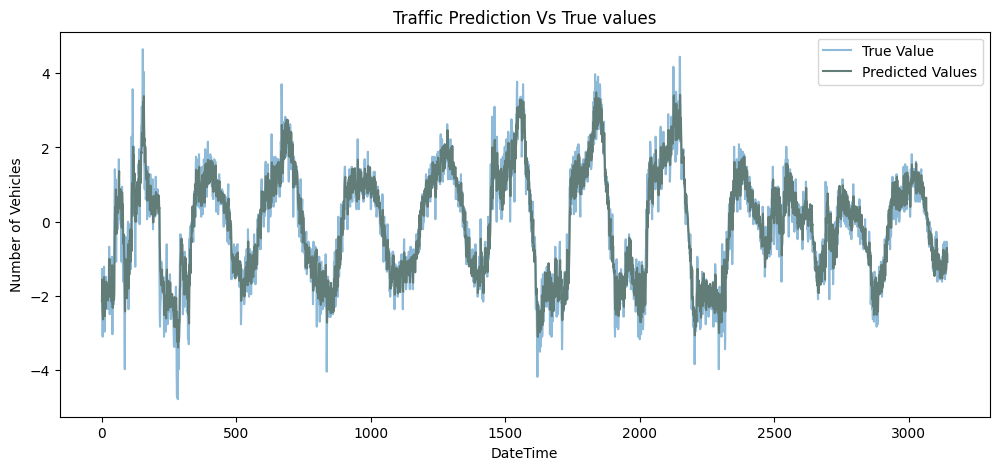


########------CNN Model------########
The root mean squared error is 0.5143982641276689.


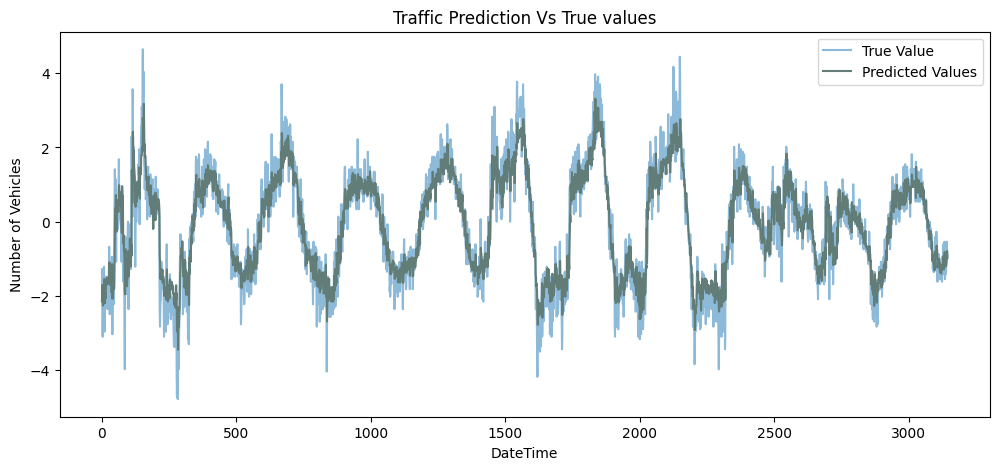


Best Model: LSTM - RMSE: 0.4776714358855156



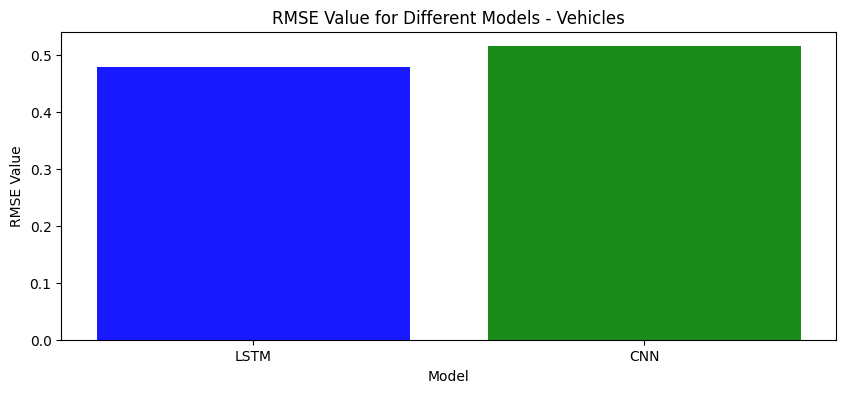

,MODEL,RMSE
0,LSTM,0.477671
1,CNN,0.514398


In [41]:
# Define colors array
colors = ['blue', 'green']

# Results for Vehicles - LSTM Model
print("\n\033[1;34;2m########------LSTM Model------########\033[0m")

# Calculate RMSE for LSTM Model and plot its predictions
RMSE_Vehicles_LSTM = RMSE_Value(y_test_vehicles, PredVehicles_LSTM)
PredictionsPlot(y_test_vehicles, PredVehicles_LSTM, 0)

# Results for Vehicles - CNN Model
print("\n\033[1;32;2m########------CNN Model------########\033[0m")

# Calculate RMSE for CNN Model and plot its predictions
RMSE_Vehicles_CNN = RMSE_Value(y_test_vehicles, PredVehicles_CNN)
PredictionsPlot(y_test_vehicles, PredVehicles_CNN, 0)

# Create a list of model names and their corresponding RMSE values
model_names = ["LSTM", "CNN"]
rmse_values = [RMSE_Vehicles_LSTM, RMSE_Vehicles_CNN]

# Create a DataFrame with model names and their corresponding rmse values
model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])

# Find the best model with the minimum RMSE value
best_model_index = rmse_values.index(min(rmse_values))
best_model_name_vehicle = model_names[best_model_index]
best_model_rmse_vehicle = rmse_values[best_model_index]

# Print the best model name and its RMSE value
print("\n\033[1;31;4mBest Model: {} - RMSE: {}\n".format(best_model_name_vehicle, best_model_rmse_vehicle))

# Plot the bar graph for model names and RMSE values with transparency and lighter colors
fig, ax = plt.subplots(figsize=(10, 4))  # Set the figure size (width, height)
ax.bar(model_names, rmse_values, color=colors[:len(model_names)], alpha=0.9)
ax.set_xlabel('Model')
ax.set_ylabel('RMSE Value')
ax.set_title('RMSE Value for Different Models - Vehicles')
plt.show()

# Display the DataFrame
display(Results_df)

### Speed

In [ ]:
print("\033[1;34;2m########------LSTM Model------########\033[0m")
Pred_speed_LSTM = LSTM_model(X_train_speed, y_train_speed, X_test_speed, y_test_speed)
print("-" * 70)
print("\033[1;32;2m########------CNN Model------########\033[0m")
Pred_speed_CNN = CNN_model(X_train_speed, y_train_speed, X_test_speed, y_test_speed)
print("-" * 70)

In [ ]:
# Define colors array
colors = ['blue', 'green']

# Results for speed - LSTM Model
print("\n\033[1;34;2m########------LSTM Model------########\033[0m")

# Calculate RMSE for LSTM Model and plot its predictions
RMSE_speed_LSTM = RMSE_Value(y_test_speed, Pred_speed_LSTM)
PredictionsPlot(y_test_speed, Pred_speed_LSTM, 0)

# Results for speed - CNN Model
print("\n\033[1;32;2m########------CNN Model------########\033[0m")

# Calculate RMSE for CNN Model and plot its predictions
RMSE_speed_CNN = RMSE_Value(y_test_speed, Pred_speed_CNN)
PredictionsPlot(y_test_speed, Pred_speed_CNN, 0)

# Create a list of model names and their corresponding RMSE values
model_names = ["LSTM", "CNN"]
rmse_values = [RMSE_speed_LSTM, RMSE_speed_CNN]

# Create a DataFrame with model names and their corresponding rmse values
model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])

# Find the best model with the minimum RMSE value
best_model_index = rmse_values.index(min(rmse_values))
best_model_name_speed = model_names[best_model_index]
best_model_rmse_speed = rmse_values[best_model_index]

# Print the best model name and its RMSE value
print("\n\033[1;31;4mBest Model: {} - RMSE: {}\n".format(best_model_name_speed, best_model_rmse_speed))

# Plot the bar graph for model names and RMSE values with transparency and lighter colors
fig, ax = plt.subplots(figsize=(10, 4))  # Set the figure size (width, height)
ax.bar(model_names, rmse_values, color=colors[:len(model_names)], alpha=0.9)
ax.set_xlabel('Model')
ax.set_ylabel('RMSE Value')
ax.set_title('RMSE Value for Different Models - Speed')
plt.show()

# Display the DataFrame
display(Results_df)

# Denormalization of the Data

In this section, we reverse the transformations applied to the datasets in order to eliminate seasonality and trends. This process will ensure that our predictions are scaled accurately.

**Denormalization of Vehicles**

In [ ]:
def inverse_difference(history, yhat, interval=1):
    return pd.Series(yhat.flatten() + history[-len(yhat) - interval:-interval].flatten())

def recover_lstm_cnn(df_N, Pred_LSTM, Pred_CNN, av, std, interval, predictor):
    recover = df_N[-len(Pred_LSTM) - interval:-interval].copy()  # Avoid chained indexing
    recover["Pred_LSTM"] = Pred_LSTM.flatten()
    recover["Pred_CNN"] = Pred_CNN.flatten()

    results = []
    for model_type, pred in [('LSTM', 'Pred_LSTM'), ('CNN', 'Pred_CNN')]:
        transform_reversed = inverse_difference(df_N['Norm'].values, recover[pred].values, interval)
        transform_reversed = pd.DataFrame(transform_reversed, columns=[f"Pred_Normed_{model_type}"])
        final_pred = Denormalize(transform_reversed.values, std, av)
        transform_reversed[f"Pred_Final_{model_type}"] = final_pred[:, 0]
        transform_reversed.index = df_N[-len(Pred_LSTM):].index  

        
        plotting_final_results(transform_reversed[f"Pred_Final_{model_type}"], 
                              df_N[-len(Pred_LSTM):], model_type, predictor)

        results.append(transform_reversed)  

    return pd.concat(results, axis=1).join(df_N[-len(Pred_LSTM):])  
    
def plotting_final_results(prediction, original_data, model_type, predictor):
    plt.figure(figsize=(12, 6))
    plt.plot(prediction, color='blue', label="Prediction")
    plt.plot(original_data[predictor], color='green', label="Original")
    plt.title(f"Traffic Prediction vs Original Values for {model_type} for {predictor}")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()
    
def Denormalize(df_normalized, stdev, average):
    df_denormalized = df_normalized * stdev + average
    return df_denormalized

## Vehicles Prediction

In [ ]:
recover_vehicles = recover_lstm_cnn(df_N_vehicles, PredVehicles_LSTM, PredVehicles_CNN, av_vehicles , std_vehicles, 24*7, "Vehicles")

In [ ]:
recover_vehicles.head()

## Speed Prediction

In [ ]:
recover_speed = recover_lstm_cnn(df_N_speed, Pred_speed_LSTM, Pred_speed_CNN, av_speed, std_speed, 24, "Speed")

In [ ]:
recover_speed.head()

In [ ]:
import pandas as pd

def save_predictions_to_csv(predictor, df):
    df.reset_index(inplace=True)
    
    if predictor not in ["Speed", "Vehicles"]:
        raise ValueError("Invalid predictor. Choose either 'Speed' or 'Vehicles'.")

    value_col = predictor
    pred_lstm_col = 'Pred_Final_LSTM'
    pred_cnn_col = 'Pred_Final_CNN'

    # Create the results DataFrame
    results_df = pd.DataFrame({
        'Junction': 646, 
        predictor: df[value_col].values,
        'DateTime': df['DateTime'].values,
        f'Predicted {predictor} Count Prediction LSTM': df[pred_lstm_col].values,
        f'Predicted {predictor} Count Prediction CNN': df[pred_cnn_col].values,
    })

    # Save to CSV
    filename = f'denormalized_predictions_{predictor.lower()}.csv'
    results_df.to_csv(filename, index=False)
    print(f"Saved predictions to {filename}")


# Example usage
save_predictions_to_csv("Speed", recover_speed)
save_predictions_to_csv("Vehicles", recover_vehicles)


**Summary**

In this project, we developed a model combining Convolutional Neural Networks (CNN) and Long Short-Term Memory (LSTM) units to forecast Traffic and Speed. To ensure a stationary time series, we implemented normalization and differencing transformations. The Root Mean Squared Error (RMSE) was utilized as the primary metric for evaluating the model's performance. Furthermore, we visualized the model's predictions by plotting them alongside the actual test data
